# This notebook analyzes FVS benchmark results and produces various graphics

In [35]:
#
# Configure these settings to reflect your local setup
#

DEEP1B_DATASETS= {  \
    "deep1M": { \
        "plottitle": "1M of Deep1B", \
        "queries": { \
            10: "results/sv7-apu12/1681855633/benchmarks-%s-q10-1681855633.csv",\
            100: "results/sv7-apu12/1681858577/benchmarks-%s-q100-1681858577.csv", \
            1000: "results/sv7-apu12/1681869282/benchmarks-%s-q1000-1681869282.csv" \
        } \
    }, \
    "deep2M": { \
        "plottitle": "2M of Deep1B", \
        "queries": { \
            10: "results/sv7-apu12/1681918498/benchmarks-%s-q10-1681918498.csv", \
            100: "results/sv7-apu12/1681922210/benchmarks-%s-q100-1681922210.csv", \
            1000: "results/sv7-apu12/1681925767/benchmarks-%s-q1000-1681925767.csv" \
        } \
    }, \
    "deep5M": {
        "plottitle": "5M of Deep1B",
        "queries": {
            10: "results/sv7-apu12/1681932765/benchmarks-%s-q10-1681932765.csv", \
            100: "results/sv7-apu12/1681946621/benchmarks-%s-q100-1681946621.csv", \
            1000: "results/sv7-apu12/1681954741/benchmarks-%s-q1000-1681954741.csv" \
        } \
    }, \
    "deep10M": {
        "plottitle": "10M of Deep1B",
        "queries": {
            10: "results/sv7-apu12/1682004069/benchmarks-%s-q10-1682004069.csv", \
            100: "results/sv7-apu12/1682019671/benchmarks-%s-q100-1682019671.csv", \
            1000: "results/sv7-apu12/1682040057/benchmarks-%s-q1000-1682040057.csv" \
        } \
    }, \
    "deep20M": {
        "plottitle": "20M of Deep1B",
        "queries": {
            10: "results/sv7-apu12/1682056666/benchmarks-%s-q10-1682056666.csv", \
            100: "results/sv7-apu12/1682090635/benchmarks-%s-q100-1682090635.csv", \
            1000: "results/sv7-apu12/1682120886/benchmarks-%s-q1000-1682120886.csv" \
        } \
    }, \
    "deep50M": {
        "plottitle": "50M of Deep1B",
        "queries": {
            10: "results/sv7-apu12/1682171705/benchmarks-%s-q10-1682171705.csv", \
        } \
    }, \
    "deep100M": {
        "plottitle": "100M of Deep1B",
        "queries": {
            10: "results/sv7-apu12/1682264855/benchmarks-%s-q10-1682264855.csv", \
        } \
    }, \
    "deep1M-clusters": { \
        "plottitle": "1M of Deep1B (clusters)", \
        "queries": { \
            10: "results/sv7-apu12/1682471082/benchmarks-%s-q10-clusters-1682471082.csv",\
            100: "results/sv7-apu12/1682471258/benchmarks-%s-q100-clusters-1682471258.csv", \
           1000: "results/sv7-apu12/1682471699/benchmarks-%s-q1000-clusters-1682471699.csv" \
        } \
    }, \
    "deep2M-clusters": { \
        "plottitle": "2M of Deep1B (clusters)", \
        "queries": { \
            10: "results/sv7-apu12/1682472462/benchmarks-%s-q10-clusters-1682472462.csv", \
            100: "results/sv7-apu12/1682472928/benchmarks-%s-q100-clusters-1682472928.csv", \
            1000: "results/sv7-apu12/1682473123/benchmarks-%s-q1000-clusters-1682473123.csv" \
        } \
    }, \
    "deep5M-clusters": {
        "plottitle": "5M of Deep1B (clusters)",
        "queries": {
            10: "results/sv7-apu12/1682474409/benchmarks-%s-q10-clusters-1682474409.csv", \
            100: "results/sv7-apu12/1682474645/benchmarks-%s-q100-clusters-1682474645.csv", \
            1000: "results/sv7-apu12/1682474886/benchmarks-%s-q1000-clusters-1682474886.csv" \
        } \
    }, \
    "deep10M-clusters": {
        "plottitle": "10M of Deep1B (clusters)",
        "queries": {
            10: "results/sv7-apu12/1682475401/benchmarks-%s-q10-clusters-1682475401.csv", \
            100: "results/sv7-apu12/1682476158/benchmarks-%s-q100-clusters-1682476158.csv", \
            1000: "results/sv7-apu12/1682477698/benchmarks-%s-q1000-clusters-1682477698.csv" \
        }\
    }\
}

NUM_APUS=4 #TODO: We should get from the allocation_id

MAIN_MEMORY_SIZE = "700G"

In [36]:
#
# Imports
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
#
# Load all the CSV files into a master dataframe
#

all_dfs= []

for dset in DEEP1B_DATASETS.keys():
    for num_queries in DEEP1B_DATASETS[dset]["queries"].keys():
        
        dset_for_subst = dset.split("-")[0]
        df = pd.read_csv( \
            DEEP1B_DATASETS[dset]["queries"][num_queries] % 
                dset_for_subst ) 
        df['dset_name'] = dset
        df['num_queries'] = num_queries
        all_dfs.append( df )


df_all = pd.concat( all_dfs )
print(df_all.shape)
print(df_all.columns)
print(df_all['dset_name'].unique())


(391, 14)
Index(['allocationid', 'datasetid', 'dataset_path', 'queries_path', 'bits',
       'ts_start', 'ts_train_start', 'ts_train_end', 'ts_query_start',
       'ts_query_end', 'response', 'recall', 'dset_name', 'num_queries'],
      dtype='object')
['deep1M' 'deep2M' 'deep5M' 'deep10M' 'deep20M' 'deep50M' 'deep100M'
 'deep1M-clusters' 'deep2M-clusters' 'deep5M-clusters' 'deep10M-clusters']


In [38]:
#
# Create throughput column
#

df_all['throughput'] = df_all.apply( \
            lambda row: row['num_queries']/row['response'], axis=1 )
    
print(df_all[["dset_name","bits","response","recall", "throughput"]])

           dset_name  bits   response  recall  throughput
0             deep1M   768   0.033413  1.0000  299.287146
1             deep1M   768   0.033241  1.0000  300.835933
2             deep1M   768   0.033140  1.0000  301.748375
3             deep1M   512   0.024154  1.0000  414.015827
4             deep1M   512   0.024518  1.0000  407.868368
..               ...   ...        ...     ...         ...
10  deep10M-clusters   128   9.941006  0.9702  100.593438
11  deep10M-clusters   128  10.073690  0.9702   99.268494
12  deep10M-clusters    64   9.353884  0.8829  106.907463
13  deep10M-clusters    64   9.359260  0.8829  106.846051
14  deep10M-clusters    64   9.471319  0.8829  105.581914

[391 rows x 5 columns]


In [39]:
# 
# Grouping rows by (num_queries,bits) and then average 'recall' and 'throughput'
# 

df_plot = \
    df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).mean()
print(df_plot)

           dset_name  num_queries  bits  recall  throughput
0           deep100M           10    64  0.7500   49.841561
1           deep100M           10   128  0.9300   30.855413
2           deep100M           10   256  0.9900   15.973566
3           deep100M           10   512  1.0000    8.074740
4            deep10M           10    64  0.8500  313.573577
..               ...          ...   ...     ...         ...
130  deep5M-clusters         1000    64  0.9160  117.840765
131  deep5M-clusters         1000   128  0.9813  113.179099
132  deep5M-clusters         1000   256  0.9976  103.443379
133  deep5M-clusters         1000   512  0.9994   91.273170
134  deep5M-clusters         1000   768  0.9996   89.732903

[135 rows x 5 columns]


In [40]:
# get min and max error bars for throughput

aggs = df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).\
                agg({'throughput': [('min_error', lambda x: x.mean() - x.min()), ('max_error', lambda x: x.max() - x.mean())]})

Saved results/gemini_fvs_deep1B-0.png
Saved results/gemini_fvs_deep1B-1.png
Saved results/gemini_fvs_deep1B-2.png
Saved results/gemini_fvs_deep1B-3.png
Saved results/gemini_fvs_deep1B-4.png
Saved results/gemini_fvs_deep1B-5.png


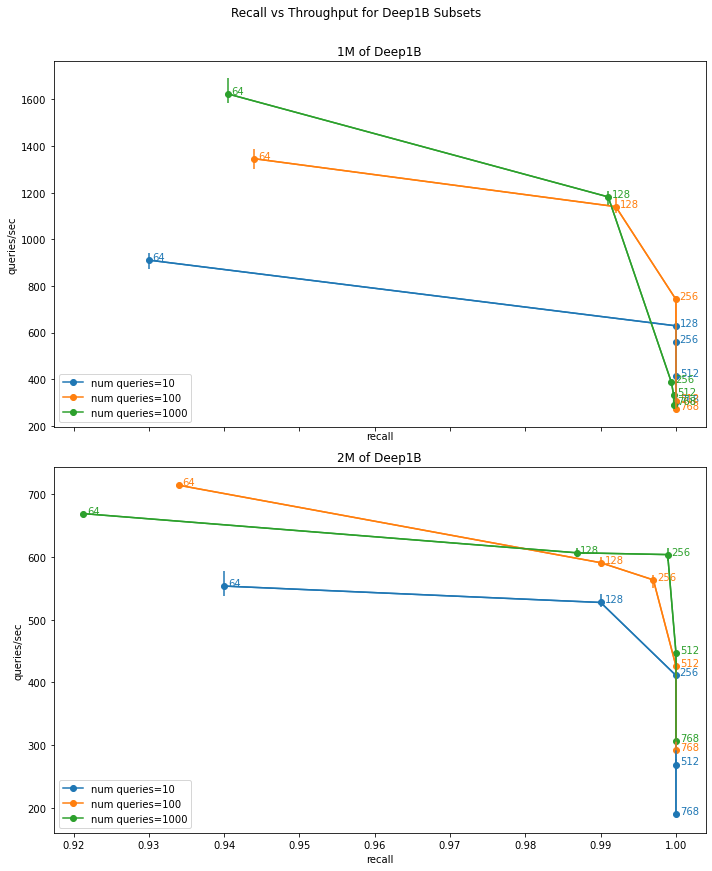

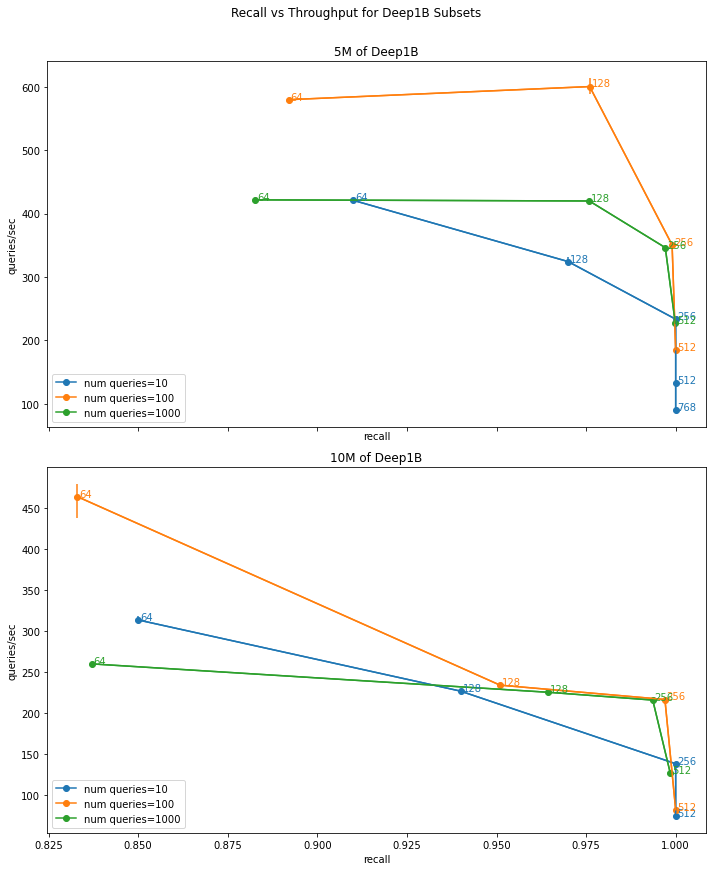

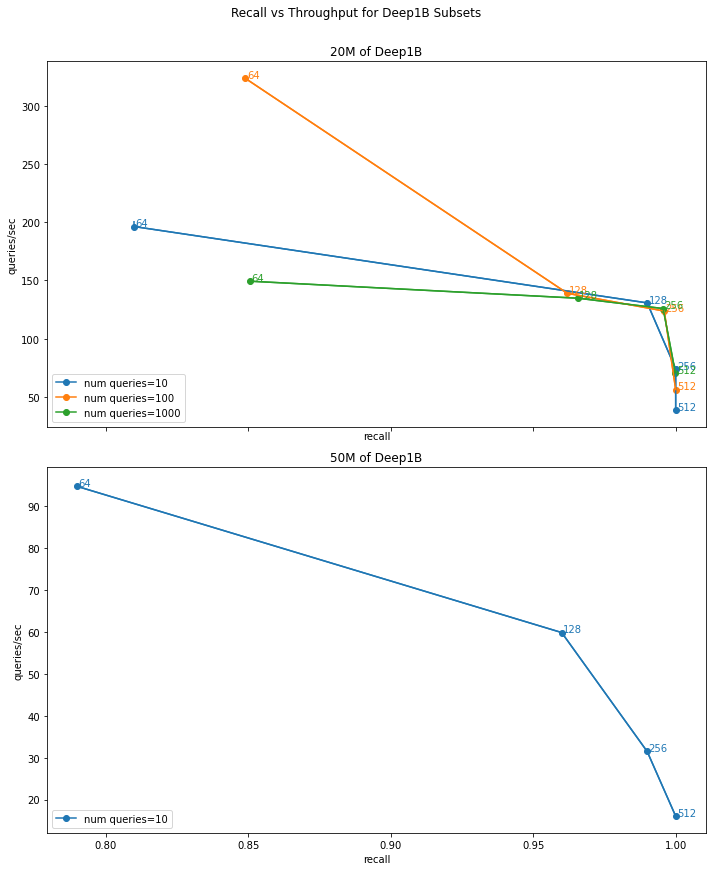

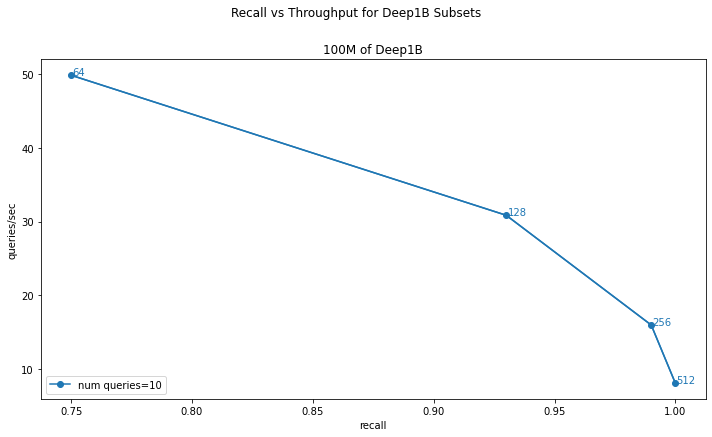

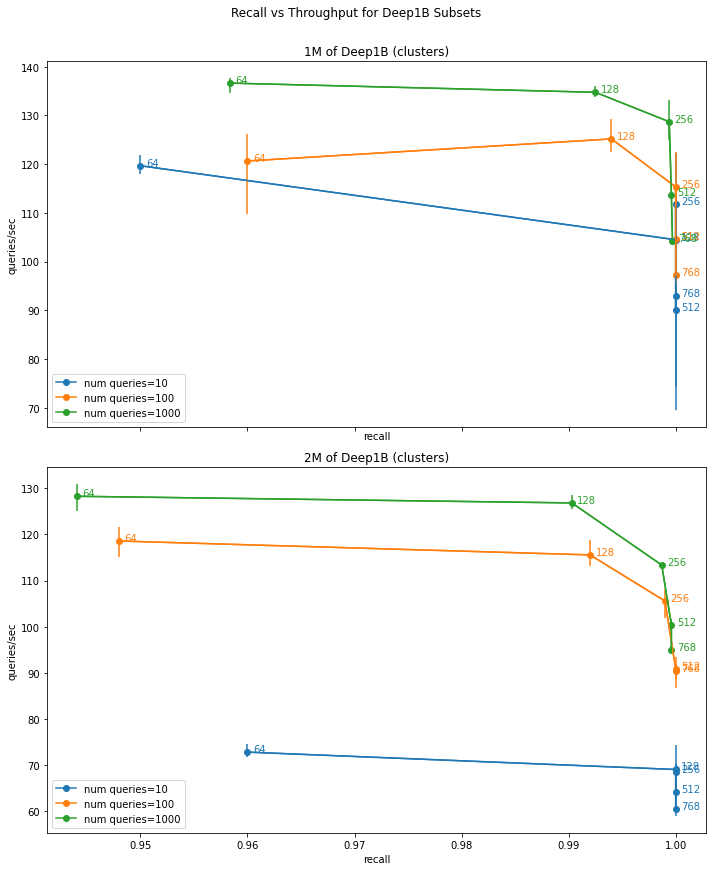

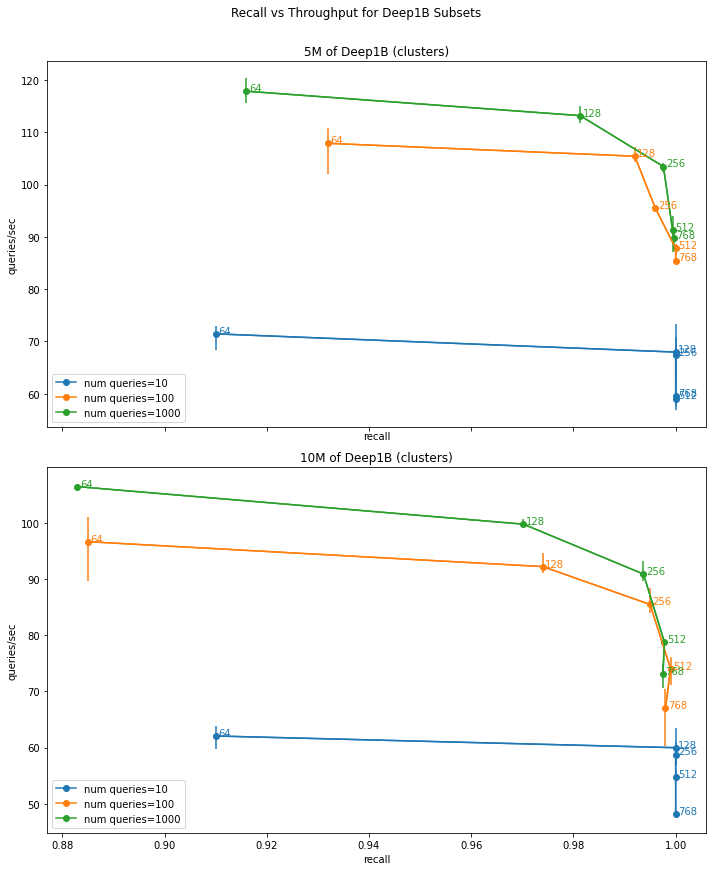

In [41]:
# 
# Plot the data
# 
num_plots = len( DEEP1B_DATASETS.keys() )

#fig, axs = plt.subplots(num_plots, sharex=True, figsize=(10,20))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for ds, dset_set in enumerate(\
    [ ["deep1M","deep2M"], ["deep5M","deep10M"], 
      ["deep20M", "deep50M"], ["deep100M"], ["deep1M-clusters","deep2M-clusters" ],
      ["deep5M-clusters","deep10M-clusters" ]]):
    
    if len(dset_set)==1:
        fig, axs = plt.subplots(1, figsize=(10,6))
        fig = [fig]
        axs = [axs]
    else:
        fig, axs = plt.subplots(2, sharex=True, figsize=(10,12))
    
    for d, dset in enumerate( dset_set ): #DEEP1B_DATASETS.keys()):

        for q, num_queries in enumerate(DEEP1B_DATASETS[dset]["queries"]):

            y_errormin = aggs.loc[ \
                (aggs['dset_name']==dset) & \
                (aggs['num_queries'] == num_queries)].\
                    throughput['min_error']
            y_errormax = aggs.loc[ \
                (aggs['dset_name']==dset) & \
                (aggs['num_queries'] == num_queries)].\
                    throughput['max_error']
            y_error = [y_errormin, y_errormax]
            recalls = df_plot.loc[ \
                    (df_plot['dset_name']==dset) & \
                    (df_plot['num_queries']==num_queries)\
                    ]["recall"]
            throughputs = df_plot.loc[ \
                    (df_plot['dset_name']==dset) & \
                    (df_plot['num_queries']==num_queries)\
                    ]["throughput"]
            bits = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["bits"]
            #print(dset, num_queries, list(recalls), list(throughputs), list(bits))
            for i in bits.index: # text for bits, added .0005 for readability
                axs[d].text(recalls[i]+.0005, throughputs[i], bits[i], color=colors[q])
            axs[d].errorbar(recalls, throughputs, yerr=y_error)
            axs[d].plot( recalls, throughputs, '-o',label="num queries=%d" % num_queries, color=colors[q])
            axs[d].set_title( DEEP1B_DATASETS[dset]["plottitle"] )
            axs[d].set_ylabel("queries/sec")
            if d==len(DEEP1B_DATASETS[dset].keys())-1:
                axs[d].set_xlabel("recall")
            axs[d].legend(loc='lower left')
            
    axs[0].set_xlabel("recall")
    if len(axs)==2: axs[1].set_xlabel("recall")
    #axs[0].set_xscale('log')
    #axs[1].set_xscale('log')
    plt.suptitle("Recall vs Throughput for Deep1B Subsets",y=1.005)
    plt.tight_layout()
    fname = "results/gemini_fvs_deep1B-%d.png" % ds
    plt.savefig(fname,bbox_inches="tight", pad_inches=0.1)
    print("Saved", fname)
        

if False:  # This was relevant for the last set of benchmarks
    # TODO: fix with a function or package maybe
    # 1M
    axs[0].texts[4].set_position((1.0007, 575.0)) #blue 768
    axs[0].texts[8].set_position((1.0, 813.0)) #orange 512
    axs[0].texts[9].set_position((1.0007, 390.0)) #orange 768
    axs[0].texts[14].set_position((1.0, 300.0)) #green 768
    # 2M
    axs[1].texts[7].set_position((0.998, 200.0)) #orage 256
    axs[1].texts[8].set_position((0.99995, 259)) #orage 512
    axs[1].texts[9].set_position((1.0006, 180.0)) #orange 765
    axs[1].texts[12].set_position((0.996, 50.0)) #green 256
    axs[1].texts[13].set_position((1.0006, 125.0)) #green 512
    axs[1].texts[14].set_position((1.0005, 50.0)) #green 768
    # 5M
    axs[2].texts[7].set_position((0.9975, 645.0))

if False: # only relevant for plotting all graphs in one plot
    axs[0].set_xlabel("recall")
    axs[1].set_xlabel("recall")
    axs[2].set_xlabel("recall")
    plt.suptitle("Recall vs Throughput for Deep1B Subsets",y=1.005)
    plt.tight_layout()
    plt.savefig("results/gemini_fvs_deep1B.png")